# Machine Learning (CS-433)
## Class Project 1
Simon Canales, Jordan Willemin, Claudio Loureiro

In [1]:
import numpy as np

from proj1_helpers import *
from implementations import *
from utils import *

# Plot libraries
import matplotlib
import matplotlib.pyplot as plt

## Loading data

In [2]:
training_pred, training_data, ids_tr = load_csv_data("../data/train.csv")
testing_pred, testing_data, ids_te = load_csv_data("../data/test.csv")

## Preprocessing

As a first step we preprocess our data, we observe that we have flags values as -999. We set it for now to 0 and this will be then treated correctly when standardizing data when doing cross-validation. Also there is a column that contains only 0, 1 and 2. Thus we increase this feature by 1 in order to not consider this value as the others 0.

In [12]:
x1 = training_data[:,29]
x2 = training_data[:,28]

In [ ]:
plt.scatter(x1,x2,cap = training_pred)

In [3]:
wrong_value = -999
training_data[training_data==wrong_value] = 0
testing_data[testing_data==wrong_value] = 0
training_data[:,22] += 1

# Least Squares Gradient Descent

We start with the least squares gradient descent. We fit a polynomial to our input data of degree 2. Then we do our cross-validation with $k_{fold} = 5$. After testing some values we quickly remark that increasing the maximum iterations above 100 and decreasing gamma below 0.01 does no longer increase the accuracy dramtically.

In [10]:
poly_degree = 2
tx = build_poly(training_data, poly_degree)
initial_w = np.zeros(tx.shape[1])
max_iters = 100
gamma = 0.01

k_fold = 5
indexes_te, indexes_tr = get_split_indexes(training_data, training_pred, k_fold)
mse_tr_mean, mse_te_mean, rmse_tr_mean, rmse_te_mean, accuracy = cross_validation(least_squares_GD, 
                                                                                   compute_mse, tx, training_pred, indexes_te, 
                                                                                   indexes_tr, k_fold, True, 
                                                                                   (initial_w, max_iters, gamma))

print('Mse: ', format(mse_te_mean))
print('Rmse: ', format(rmse_te_mean))
print('Accuracy: ', format(accuracy))

Mse:  0.35087575462902754
Rmse:  0.8377060995707594
Accuracy:  0.749096


# Least Squares Stochastic Gradient Descent

Least squares stochastic gradient descent. Agains it works as the least squares gradient descent but at each iteration we only take one sample of the dataset. The we naturally have to do more iterations than the gradient descent. Again we fit a polynomial to the dataset and perform a cross-validation with $k_{fold} = 5$

In [36]:
poly_degree = 5
tx = build_poly(training_data, poly_degree)
initial_w = np.zeros(tx.shape[1])
max_iters = 500
gamma = 0.00001

k_fold = 5
indexes_te, indexes_tr = get_split_indexes(training_data, training_pred, k_fold)
mse_tr_mean, mse_te_mean, rmse_tr_mean, rmse_te_mean, accuracy = cross_validation(least_squares_SGD, 
                                                                                  compute_mse, tx, training_pred, indexes_te, 
                                                                                  indexes_tr, k_fold, True, 
                                                                                  (initial_w, max_iters, gamma))

print('Mse: ', format(mse_te_mean))
print('Rmse: ', format(rmse_te_mean))
print('Accuracy: ', format(accuracy))

Mse:  0.49198847363399467
Rmse:  0.9919561216444956
Accuracy:  0.6828520000000002


# Least Squares

Compared to other methods least squares is not an iterative method. Instead we have to resolve a system in order to minimize our weight matrix. Again, we fit a polynomial to the data set of degree 3 and perform a cross-validation with $k_{fold} = 4$ 

In [29]:
poly_degree = 3
tx = build_poly(training_data, poly_degree)

k_fold = 4
indexes_te, indexes_tr = get_split_indexes(training_data, training_pred, k_fold)
mse_tr_mean, mse_te_mean, rmse_tr_mean, rmse_te_mean, accuracy = cross_validation(least_squares, 
                                                                                  compute_mse, tx, training_pred, indexes_te, 
                                                                                  indexes_tr, k_fold, True)

print('Mse: ', format(mse_te_mean))
print('Rmse: ', format(rmse_te_mean))
print('Accuracy: ', format(accuracy))

Mse:  0.3222919637939099
Rmse:  0.8028598430534559
Accuracy:  0.780356


# Ridge regression 

The ridge regression is an improved version of the least squares method denoted above. It adds a regularization term. This method proved allowed us to have the best results in term of accuracy. Thus we will optimize our parameters to achieve the best possible accuracy.

In [4]:
poly_degree = 15
tx = build_poly(training_data, poly_degree)
lambda_ = 1e-15

k_fold = 5
indexes_te, indexes_tr = get_split_indexes(training_data, training_pred, k_fold)
mse_tr_mean, mse_te_mean, rmse_tr_mean, rmse_te_mean, accuracy = cross_validation(ridge_regression, 
                                                                                  compute_mse, tx, training_pred, indexes_te, 
                                                                                  indexes_tr, k_fold, True, (lambda_,))

print('Mse: ', format(mse_te_mean))
print('Rmse: ', format(rmse_te_mean))
print('Accuracy: ', format(accuracy))

Mse:  29179899974.323742
Rmse:  241577.7306554714
Accuracy:  0.439816


### Tuning lambda

First we will try to find the lambda that gives us the best accuracy. We will iterate through a list of lambdas and perform a cross validation for each.

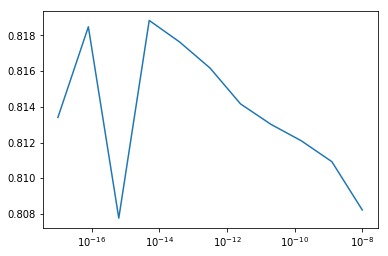

In [18]:
poly_degree = 12
tx = build_poly(training_data, poly_degree)
lambda_vec = np.logspace(-7, -17, 10)
accuracy_vec = []

k_fold = 4

indexes_te, indexes_tr = get_split_indexes(training_data, training_pred, k_fold)

for lambda_ in lambda_vec:
    mse_tr_mean, mse_te_mean, rmse_tr_mean, rmse_te_mean, accuracy = cross_validation(ridge_regression, 
                                                                                      compute_mse, tx, training_pred, indexes_te, 
                                                                                      indexes_tr, k_fold, True, (lambda_,))
    accuracy_vec.append(accuracy)
    
plt.semilogx(lambda_vec, accuracy_vec)
plt.show()

In [36]:
degrees_vec = np.linspace(8, 18, 10)
lambdas_vec = np.logspace(-8, -16, 9)
print(degrees_vec)
print(lambdas_vec)
k_fold = 5

rmse_te_mean_arr = np.zeros((len(lambdas_vec), len(degrees_vec)))
mse_te_mean_arr = np.zeros_like(rmse_te_mean_arr)
accuracy_arr = np.zeros_like(rmse_te_mean_arr)

for i, degree in enumerate(degrees_vec):
    tx = build_poly(training_data, int(degree))
    indexes_te, indexes_tr = get_split_indexes(training_data, training_pred, k_fold)
    for j, lambda_ in enumerate(lambda_vec):
        print(i,j)
        mse_tr_mean, mse_te_mean, rmse_tr_mean, rmse_te_mean, accuracy = cross_validation(ridge_regression, 
                                                                                    compute_mse, tx, training_pred, indexes_te, 
                                                                                    indexes_tr, k_fold, True, (lambda_,))
        accuracy_arr[j][i] = accuracy

[  8.   9.  10.  11.  12.  13.  14.]
[  1.00000000e-08   1.00000000e-09   1.00000000e-10   1.00000000e-11
   1.00000000e-12   1.00000000e-13   1.00000000e-14   1.00000000e-15
   1.00000000e-16]


# Logistic regression

In [5]:
training_pred_log = training_pred.copy()
training_pred_log[training_pred_log==-1] = 0

In [6]:
poly_degree = 10
tx = build_poly(training_data, poly_degree)
initial_w = np.zeros(tx.shape[1])

max_iters = 200
gamma = 0.00001

k_fold = 4
indexes_te, indexes_tr = get_split_indexes(training_data, training_pred, k_fold)
mse_tr_mean, mse_te_mean, rmse_tr_mean, rmse_te_mean, accuracy = cross_validation(logistic_regression, loss_logistic_regression,
                                                                                  tx, training_pred_log, indexes_te, 
                                                                                  indexes_tr, k_fold, True, 
                                                                                  (initial_w, max_iters, gamma))

print('Negative log likelihood: ', format(mse_te_mean))
print('Rmse: ', format(rmse_te_mean))
print('Accuracy: ', format(accuracy))

Negative log likelihood:  0.6920867021048016
Rmse:  1.1765089902799737
Accuracy:  0.6768280000000001


# Regularized Logistic Regression

In [7]:
poly_degree = 12
tx = build_poly(training_data, poly_degree)
initial_w = np.zeros(tx.shape[1])

lambda_ = 1
max_iters = 200
gamma = 0.00001

k_fold = 4
indexes_te, indexes_tr = get_split_indexes(training_data, training_pred, k_fold)
mse_tr_mean, mse_te_mean, rmse_tr_mean, rmse_te_mean, accuracy = cross_validation(reg_logistic_regression, 
                                                                                  reg_logistic_regression_loss,
                                                                                  tx, training_pred_log, indexes_te, 
                                                                                  indexes_tr, k_fold, True, 
                                                                                  (lambda_, initial_w, max_iters, gamma),
                                                                                  (lambda_,))

print('Negative log likelihood: ', format(mse_te_mean))
print('Rmse: ', format(rmse_te_mean))
print('Accuracy: ', format(accuracy))

Negative log likelihood:  0.6920153614956716
Rmse:  1.176448351178811
Accuracy:  0.67778
